In [1]:
# set up keras 3 and gpu 
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.config.set_backend("torch")

import torch
print("Keras backend:", keras.backend.backend())
print("CUDA available:", torch.cuda.is_available())


Keras backend: torch
CUDA available: True


In [2]:


import numpy as np
import pandas as pd
import random

random.seed(13)
np.random.seed(13)


In [3]:

import sys
sys.path.append(os.path.abspath("../src"))  # <- locate models and utilities


In [4]:
# Data Load & Tensor Build
from data.loader import load_and_clean_raw_dataset
from data.dataset_builder import build_full_surface_feature_df
from data.tensor_builder import prepare_surface_and_feature_tensors
import numpy as np

df_raw = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")
df_all = df_all.dropna()

iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]

tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df_raw,
    feat_cols=feat_cols,
    monthly_interpolation=False
)

# Pipeline Constants
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = len(feat_cols)
LOOKBACK = 20
M, K = SURFACE_SHAPE
BATCH_SIZE = 32
T = tensors["surface_tensor"].shape[0]
print(f"FEATURE_DIM: {FEATURE_DIM}, T: {T}")

FEATURE_DIM: 26, T: 1258


In [5]:
# Check data scales
print("Surface tensor info:")
print(f"  Shape: {tensors['surface_tensor'].shape}")
print(f"  Range: [{tensors['surface_tensor'].min():.4f}, {tensors['surface_tensor'].max():.4f}]")
print(f"  Mean: {tensors['surface_tensor'].mean():.4f}, Std: {tensors['surface_tensor'].std():.4f}")

print("\nX_feat_tensor info:")
print(f"  Shape: {X_feat_tensor.shape}")
print(f"  Range: [{X_feat_tensor.min():.4f}, {X_feat_tensor.max():.4f}]")

# Check what a decoder expects vs what it gets
sample_surface = tensors["surface_tensor"][0, :, :, -1].reshape(1, -1)
print(f"\nSample surface for decoder:")
print(f"  Shape: {sample_surface.shape}")
print(f"  Range: [{sample_surface.min():.4f}, {sample_surface.max():.4f}]")

# In BOTH notebooks
print(f"df_all columns: {len(df_all.columns)}")
print(f"IV columns: {len([c for c in df_all.columns if c.startswith('IV_')])}")
print(f"Non-IV columns: {len([c for c in df_all.columns if not c.startswith('IV_')])}")

# Check what columns are there
non_iv_cols = [c for c in df_all.columns if not c.startswith("IV_")]
print(f"First 10 non-IV columns: {non_iv_cols[:10]}")
print(f"Last 10 non-IV columns: {non_iv_cols[-10:]}")

Surface tensor info:
  Shape: torch.Size([1258, 11, 10, 6])
  Range: [0.0000, 9216.2246]
  Mean: 1518.7891, Std: 2261.5378

X_feat_tensor info:
  Shape: torch.Size([1258, 136])
  Range: [-3.6510, 3.6939]

Sample surface for decoder:
  Shape: torch.Size([1, 110])
  Range: [0.1674, 0.7193]
df_all columns: 136
IV columns: 110
Non-IV columns: 26
First 10 non-IV columns: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y', 'rate_0.5y', 'rate_1y', 'rate_2y']
Last 10 non-IV columns: ['slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope', 'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg', 'ts_split_slope']


In [6]:
# Model Loading 


import keras
import torch
from keras.models import load_model
from keras.saving import register_keras_serializable
from models.vae_mle import sample_z
from models.decoder import SimpleSurfaceDecoder, PiecewiseSurfaceDecoder
from models.transformer import TransformerForecaster, TransformerForecasterV2
from models.pointwise_moe import PiecewiseSurfaceDecoderModular
from models.gru import GRUForecasterAugmented

# serialization workaround for Lambda layers in saved models
# Some models contain Lambda layers that need to be registered for loading
# we use a placeholder function to maintain compatibility
@register_keras_serializable()
def custom_lambda(x):
   
    import keras.ops as ops
    return ops.ones_like(x) * ops.log(ops.ones(1))  # Returns zeros



custom_objects = {
    "sample_z": sample_z,
    "SimpleSurfaceDecoder": SimpleSurfaceDecoder,
    "PiecewiseSurfaceDecoder": PiecewiseSurfaceDecoder,
    "PiecewiseSurfaceDecoderModular": PiecewiseSurfaceDecoderModular,
    "TransformerForecaster": TransformerForecaster,
    "TransformerForecasterV2": TransformerForecasterV2,
    "GRUForecasterAugmented": GRUForecasterAugmented,  # ADD THIS
    "ops": keras.ops,
    "custom_lambda": custom_lambda
}


# Registries
ENCODER_REGISTRY = {
    "AE": "saved_models/ae/ae_encoder.keras",
    "VAE_MLE": "saved_models/vae_mle/vae_mle_encoder.keras",
    "VAE": "saved_models/vae_gru_moe/encoder_vae.keras",
    "FW_PCA": None,  # Created programmatically
    "PCA": None,  # Created programmatically
}

TEMPORAL_REGISTRY = {
    "ATTN-AE": "saved_models/attention/attention_model_ae.keras",
    "ATTN-VAE": "saved_models/attention/attention_model_vae.keras", 
    "ATTN-PCA": "saved_models/attention/attention_model_pca.keras",
    "ATTN-FW_PCA": "saved_models/attention/attention_model_fwpca.keras",
    "GRU-AE": "saved_models/gru/gru_model_ae.keras",
    "GRU-PCA": "saved_models/gru/gru_model_pca.keras",
    "GRU-VAE": "saved_models/vae_gru_moe/gru_temporal.keras",
    "GRU-FW_PCA": "saved_models/gru/gru_model_fwpca.keras",
    "LSTM-AE": "saved_models/lstm/lstm_model_ae.keras",
    "LSTM-VAE": "saved_models/lstm/lstm_model_vae.keras",
    "LSTM-PCA": "saved_models/lstm/lstm_model_pca.keras", #"saved_models/lstm/lstm_model_pca.keras")
    "LSTM-ATTN-AE": "saved_models/lstm_attn/lstm_model_ae.keras",
    "LSTM-ATTN-VAE": "saved_models/lstm_attn/lstm_model_vae.keras",
    "LSTM-ATTN-PCA": "saved_models/lstm_attn/lstm_model_pca.keras",
    "LSTM-ATTN-FW_PCA": "saved_models/lstm_attn/lstm_attn_fwpca.keras",
    "LSTM-FW_PCA": "saved_models/lstm/lstm_model_fwpca.keras",
    "TRFM-AE": "saved_models/transformer/transformer_model_ae.keras",
    "TRFM-VAE": "saved_models/transformer/transformer_model_vae.keras",
    "TRFM-PCA": "saved_models/transformer/transformer_model_pca.keras",  
    "TRFM-FW_PCA": "saved_models/transformer/transformer_model_fwpca.keras",
    "TRFM-V2-AE": "saved_models/transformer_v2/transformer_v2_ae_model.keras",
    "TRFM-V2-VAE": "saved_models/transformer_v2/transformer_v2_vae_model.keras",
    "TRFM-V2-PCA": "saved_models/transformer_v2/transformer_v2_model.keras",  
    "TRFM-V2-FW_PCA": "saved_models/transformer_v2/transformer_v2_model_fwpca.keras",
}

DECODER_REGISTRY = {
    "AE": "saved_models/ae/ae_decoder.keras",
    "VAE_MLE": "saved_models/vae_mle/vae_mle_decoder.keras",         
    "VAE": "saved_models/vae_gru_moe/decoder_vae.keras",
    "FW_PCA": None,  # Created programmatically
    "PCA": None,  # Created programmatically
}

CORRECTIVE_DECODER_REGISTRY = { 
    "AE_PW": "saved_models/ae/piecewise_surface_mod_moe/decoder.keras",
    "VAE_PW": "saved_models/vae_gru_moe/decoder_final.keras",
    #"VAE_MLE_PW": "saved_models/vae/piecewise_surface_mod_moe/decoder_final.keras",
    "VAE_MLE_PW": "saved_models/piecewise_surface_mod_moe_2/decoder.keras",
    "FW_PCA_PW": "saved_models/fwpca/piecewise_surface_mod_moe_2/decoder.keras",
    "PCA_PW": "saved_models/ae/piecewise_surface_mod_moe/decoder.keras",  # Reuse AE corrective for PCA
}



In [7]:
import os
from pathlib import Path
# Check all registries
def check_models(registry_name, registry):
    print(f"\n{registry_name}:")
    print("-" * 50)
    missing = []
    exists = []
    
    for key, path in registry.items():
        if path is None:
            print(f"  {key:20} → Programmatic (no file)")
        elif Path(path).exists():
            size_mb = Path(path).stat().st_size / (1024*1024)
            print(f"  {key:20} ✓ {path} ({size_mb:.1f} MB)")
            exists.append(key)
        else:
            print(f"  {key:20} ✗ MISSING: {path}")
            missing.append(key)
    
    print(f"\nSummary: {len(exists)} found, {len(missing)} missing")
    return missing

# Run checks
missing_encoders = check_models("ENCODER_REGISTRY", ENCODER_REGISTRY)
missing_temporal = check_models("TEMPORAL_REGISTRY", TEMPORAL_REGISTRY)
missing_decoders = check_models("DECODER_REGISTRY", DECODER_REGISTRY)
missing_corrective = check_models("CORRECTIVE_DECODER_REGISTRY", CORRECTIVE_DECODER_REGISTRY)

# Show what directories actually exist
print("\n\nActual saved_models structure:")
for root, dirs, files in os.walk("saved_models"):
    level = root.replace("saved_models", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for file in files:
        if file.endswith('.keras'):
            print(f"{subindent}{file}")


ENCODER_REGISTRY:
--------------------------------------------------
  AE                   ✓ saved_models/ae/ae_encoder.keras (1.2 MB)
  VAE_MLE              ✓ saved_models/vae_mle/vae_mle_encoder.keras (1.2 MB)
  VAE                  ✓ saved_models/vae_gru_moe/encoder_vae.keras (1.2 MB)
  FW_PCA               → Programmatic (no file)
  PCA                  → Programmatic (no file)

Summary: 3 found, 0 missing

TEMPORAL_REGISTRY:
--------------------------------------------------
  ATTN-AE              ✓ saved_models/attention/attention_model_ae.keras (0.1 MB)
  ATTN-VAE             ✓ saved_models/attention/attention_model_vae.keras (0.1 MB)
  ATTN-PCA             ✓ saved_models/attention/attention_model_pca.keras (0.1 MB)
  ATTN-FW_PCA          ✓ saved_models/attention/attention_model_fwpca.keras (0.1 MB)
  GRU-AE               ✓ saved_models/gru/gru_model_ae.keras (0.6 MB)
  GRU-PCA              ✓ saved_models/gru/gru_model_pca.keras (0.6 MB)
  GRU-VAE              ✓ saved_models/v

Note: for PCA and FW_PCA, there are no saved models so we need to re-import the components 

In [8]:
from keras import ops
from models.fw_pca import FeatureWeightedPCA, FWPCAEncoderWrapper, FWPCADecoderWrapper
from models.encoder_pca import PCAEncoder, PCAEncoderWrapper, PCADecoderWrapper

def create_fwpca_components(tensors, X_feat_tensor, M, K, latent_dim=12):
    """Create FW_PCA encoder and decoder components for pipeline."""
    surface_tensor = tensors["surface_tensor"]
    X_surface_tensor = surface_tensor[..., -1].reshape(surface_tensor.shape[0], -1)
    
    # Initialize and fit FW_PCA
    fwpca = FeatureWeightedPCA(n_components=latent_dim)
    fwpca.fit(X_surface_tensor, X_feat_tensor)

    encoder_fwpca = FWPCAEncoderWrapper(fwpca, X_feat_tensor, M, K)
    decoder_fwpca = FWPCADecoderWrapper(encoder_fwpca)

    return encoder_fwpca, decoder_fwpca



def create_pca_components(tensors, M, K, latent_dim=12):
    """Create PCA encoder and decoder components for pipeline."""
    surface_tensor = tensors["surface_tensor"]
    X_surface_tensor = surface_tensor[..., -1].reshape(surface_tensor.shape[0], -1)
    X_surface_numpy = ops.convert_to_numpy(X_surface_tensor)
    
    # Initialize and fit PCA
    pca = PCAEncoder(n_components=latent_dim)
    pca.fit_transform(X_surface_numpy)
    
    encoder_pca = PCAEncoderWrapper(pca, M, K)
    decoder_pca = PCADecoderWrapper(encoder_pca)
    
    return encoder_pca, decoder_pca

# Create FW_PCA components
fwpca_encoder, fwpca_decoder = create_fwpca_components(
    tensors, X_feat_tensor, M, K, LATENT_DIM
)

# Create PCA components
pca_encoder, pca_decoder = create_pca_components(
    tensors, M, K, LATENT_DIM
)

In [9]:

pipelines = {}

# All valid pipeline combinations
valid_combinations = [
    #AE Family
    ("AE", "ATTN-AE", "AE", "AE_PW"),
    ("AE", "LSTM-AE", "AE", "AE_PW"),
    ("AE", "LSTM-ATTN-AE", "AE", "AE_PW"),
    ("AE", "GRU-AE", "AE", "AE_PW"),
    ("AE", "TRFM-AE", "AE", "AE_PW"),
    ("AE", "TRFM-V2-AE", "AE", "AE_PW"),

    #VAE Family
    ("VAE", "GRU-VAE", "VAE", "VAE_PW"),
    ("VAE_MLE", "LSTM-VAE", "VAE_MLE", "VAE_MLE_PW"),
    ("VAE_MLE", "LSTM-ATTN-VAE", "VAE_MLE", "VAE_MLE_PW"),
    ("VAE_MLE", "TRFM-VAE", "VAE_MLE", "VAE_MLE_PW"),
    ("VAE_MLE", "TRFM-V2-VAE", "VAE_MLE", "VAE_MLE_PW"),
    ("VAE_MLE", "ATTN-VAE", "VAE_MLE", "VAE_MLE_PW"),

    # FW_PCA Family
    ("FW_PCA", "GRU-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    ("FW_PCA", "LSTM-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    ("FW_PCA", "LSTM-ATTN-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    ("FW_PCA", "TRFM-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    ("FW_PCA", "TRFM-V2-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    ("FW_PCA", "ATTN-FW_PCA", "FW_PCA", "FW_PCA_PW"),
    
    #PCA Family - 
    ("PCA", "GRU-PCA", "PCA", "AE_PW"),  # Use AE corrective for PCA
    ("PCA", "LSTM-PCA", "PCA", "AE_PW"),
    ("PCA", "LSTM-ATTN-PCA", "PCA", "AE_PW"),
    ("PCA", "ATTN-PCA", "PCA", "AE_PW"),
    ("PCA", "TRFM-PCA", "PCA", "AE_PW"),
    ("PCA", "TRFM-V2-PCA", "PCA", "AE_PW"),
]

for enc_key, temp_key, dec_key, corr_key in valid_combinations:
    try:
        # Special handling for programmatic components
        if enc_key == "FW_PCA":
            encoder = fwpca_encoder
            decoder = fwpca_decoder
        elif enc_key == "PCA":  # ADD PCA HANDLING
            encoder = pca_encoder
            decoder = pca_decoder
        else:
            encoder = load_model(ENCODER_REGISTRY[enc_key], custom_objects=custom_objects, compile=False)
            decoder = load_model(DECODER_REGISTRY[dec_key], custom_objects=custom_objects, compile=False)
        
        # Check if temporal model exists
        if temp_key not in TEMPORAL_REGISTRY:
            print(f"Skipped: {enc_key}_{temp_key} - not in registry")
            continue
            
        temporal_path = TEMPORAL_REGISTRY[temp_key]
        if temporal_path and not os.path.exists(temporal_path):
            print(f"Skipped: {enc_key}_{temp_key} - file not found")
            continue
            
        temporal = load_model(temporal_path, custom_objects=custom_objects, compile=False)
        
        # Load corrective decoder
        corrective_path = CORRECTIVE_DECODER_REGISTRY[corr_key]
        if not os.path.exists(corrective_path):
            print(f"Failed: {enc_key}_{temp_key} - corrective not found at {corrective_path}")
            continue
            
        corrective = load_model(corrective_path, custom_objects=custom_objects, compile=False)
        
        pipeline_name = f"{enc_key}_{temp_key}_{dec_key}_{corr_key}"
        pipelines[pipeline_name] = {
            'encoder': encoder,
            'temporal': temporal,
            'decoder': decoder,
            'corrective': corrective
        }
        #print(f"Loaded: {pipeline_name}")
        
    except Exception as e:
        print(f"Failed: {enc_key}_{temp_key}_{dec_key}_{corr_key} - {str(e)[:60]}")

print(f"\nTotal pipelines loaded: {len(pipelines)}")
print(f"Families: AE ({sum(1 for p in pipelines if p.startswith('AE_'))}), "
      f"VAE ({sum(1 for p in pipelines if p.startswith('VAE_'))}), "
      f"PCA ({sum(1 for p in pipelines if p.startswith('PCA_'))}), "  # ADD PCA COUNT
      f"FW_PCA ({sum(1 for p in pipelines if p.startswith('FW_PCA'))})")

Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7


c:\Users\alessandro.esposito\source\repos\imperial\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=0, Free=8, Total=8
Expert allocation: ATM=0, Maturity=0, Free=8, Total=8
Expert allocation: ATM=0, Maturity=0, Free=8, Total=8
Expert allocation: ATM=0, Maturity=0, Free=8, Total=8
Expert allocation: ATM=0, Maturity=0, Free=8, Total=8
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Maturity=4, Free=3, Total=7
Expert allocation: ATM=0, Ma

In [10]:
# Just check pipelines loaded
print(f"Pipelines loaded: {len(pipelines)}")
for name in list(pipelines.keys())[:3]:
    print(f"\n{name}:")
    print(f"  Encoder: {pipelines[name]['encoder']}")
    print(f"  Temporal: {pipelines[name]['temporal']}")
    print(f"  Decoder: {pipelines[name]['decoder']}")
    print(f"  Corrective: {pipelines[name]['corrective']}")

Pipelines loaded: 24

AE_ATTN-AE_AE_AE_PW:
  Encoder: <Functional name=ae_encoder, built=True>
  Temporal: <Functional name=attention_forecaster, built=True>
  Decoder: <Functional name=ae_decoder, built=True>
  Corrective: <PiecewiseSurfaceDecoderModular name=piecewise_surface_decoder_modular, built=True>

AE_LSTM-AE_AE_AE_PW:
  Encoder: <Functional name=ae_encoder, built=True>
  Temporal: <Functional name=lstm_forecaster_augmented, built=True>
  Decoder: <Functional name=ae_decoder, built=True>
  Corrective: <PiecewiseSurfaceDecoderModular name=piecewise_surface_decoder_modular_1, built=True>

AE_LSTM-ATTN-AE_AE_AE_PW:
  Encoder: <Functional name=ae_encoder, built=True>
  Temporal: <Functional name=lstm_with_attention_augmented, built=True>
  Decoder: <Functional name=ae_decoder, built=True>
  Corrective: <PiecewiseSurfaceDecoderModular name=piecewise_surface_decoder_modular_2, built=True>


#### Transofrmer V2 Model Compatibility Layer

During development, we found that V2 transformer models had a preprocessing bug where the feature centering wasn't consistent between training and testing. Rather than retrain everything (which takes forever), these helper functions patch the issue so we can still run the models and include them in our comparison. The main problem is that V2 models were trained with features scaled one way, but at test time they were getting features scaled differently. This mismatch definitely hurts performance but doesn't completely break the models. It probably explains why the transformers underperform compared to simpler RNN models. These helper functions work around the issue by handling all the different encoder quirks. VAE encoders return three outputs but we only need the mean, PCA encoders only take surface data not features, and each encoder has its own format. The functions also pad or trim features to match what the models expect from training, since the feature dimensions might have changed. Everything gets stitched together in the right order since V2 models expect features and latent codes concatenated in a specific way. Not ideal, but it lets us test V2 models without waiting hours for retraining. At least we can include them in the pipeline comparison even if we know they're handicapped by this preprocessing issue.

In [11]:
# Helper Functions for V2 Models
# V2 models require special preprocessing because they combine latent codes with features

def encode_timestep_for_v2(encoder, surface_t, feat_t, pipeline_name):
    """Encode a single timestep for V2 transformer models.
    Different encoders require different input formats."""
    if 'PCA' in pipeline_name:
        # PCA encoder only processes surface data
        z_t = encoder.predict(surface_t)
    elif 'VAE' in pipeline_name:
        # VAE returns tuple (sampled_z, z_mean, z_logvar), we need z_mean
        full_input = np.concatenate([surface_t, feat_t], axis=-1)
        z_output = encoder(full_input, training=False)
        z_t = z_output[1] if isinstance(z_output, (list, tuple)) else z_output
        z_t = ops.convert_to_numpy(z_t)
    else:
        # AE/FW_PCA encoders process combined surface+features
        full_input = np.concatenate([surface_t, feat_t], axis=-1)
        z_t = encoder.predict(full_input, verbose=0)
    return z_t

def encode_target_for_v2(encoder, target_flat, target_feat, pipeline_name):
    """Encode target timestep for V2 models loss computation."""
    if 'PCA' in pipeline_name:
        z_target = encoder.predict(target_flat)
    else:
        target_full = np.concatenate([target_flat, target_feat], axis=-1)
        z_target = encoder.predict(target_full, verbose=0)
    
    # Handle VAE output format
    if 'VAE' in pipeline_name:
        z_target = ops.convert_to_numpy(z_target)
    elif isinstance(z_target, (list, tuple)):
        z_target = z_target[1]
    
    return z_target

def process_v2_batch(batch, encoder, pipeline_name, config, lookback, M, K):
    """Process batch for V2 transformers which expect [features, latents] input.
    V2 models concatenate market features with encoded latents at each timestep."""
    
    # Extract and convert tensors
    (surface_seq, feat_seq), target_surface = batch
    surface_seq = ops.convert_to_numpy(surface_seq)
    feat_seq = ops.convert_to_numpy(feat_seq)
    target_surface = ops.convert_to_numpy(target_surface)
    
    batch_size = surface_seq.shape[0]
    actual_feat_dim = feat_seq.shape[-1]
    
    # V2 models have fixed input dimensions from training
    expected_input_dim = config['input_dim']
    expected_latent_dim = config['latent_dim']
    expected_feat_dim = expected_input_dim - expected_latent_dim
    
    # Encode each timestep in sequence
    latent_seq = []
    for t in range(lookback):
        surface_t = surface_seq[:, t, :, :, -1].reshape(batch_size, M*K)
        feat_t = feat_seq[:, t, :]
        z_t = encode_timestep_for_v2(encoder, surface_t, feat_t, pipeline_name)
        latent_seq.append(z_t)
    
    latent_seq = np.stack(latent_seq, axis=1)
    
    # Pad or truncate features to match model's expected dimensions
    if actual_feat_dim > expected_feat_dim:
        feat_seq_reduced = feat_seq[:, :, :expected_feat_dim]
    else:
        padding = np.zeros((batch_size, lookback, expected_feat_dim - actual_feat_dim))
        feat_seq_reduced = np.concatenate([feat_seq, padding], axis=-1)
    
    # Combine features and latents for V2 input format
    combined = np.concatenate([feat_seq_reduced, latent_seq], axis=-1)
    
    # Encode target for loss computation
    target_flat = target_surface[:, :, :, -1].reshape(batch_size, M*K)
    target_feat = feat_seq[:, -1, :]
    z_target = encode_target_for_v2(encoder, target_flat, target_feat, pipeline_name)
    
    return combined, z_target

In [12]:
# Complete Pipeline Evaluation
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from data.dataset import FeatureToLatentSequenceDataset
from models.lstm import EncodedLatentSequence
from utils.eval import summarize_latent_errors
from models.encoder_pca import PCAEncoder, PCAEncoderWrapper, PCADecoderWrapper, PCAEncodedLatentSequence
from data.edav import check_no_arbitrage_total_variance
from keras import ops

def evaluate_pipeline(pipeline_name, pipeline, tolerance=0.005):
    """Evaluate a complete forecasting pipeline end-to-end."""
    encoder = pipeline['encoder']
    temporal = pipeline['temporal']
    decoder = pipeline['decoder']
    corrective = pipeline['corrective']
    
    # Patch VAE encoder to return z_mean instead of tuple
    if 'VAE' in pipeline_name:
        encoder.predict = lambda x, **kwargs: encoder(x, training=False)[1]
    
    lookback = 20 if 'TRFM' in pipeline_name else LOOKBACK
    
    # Check for V2 model (has feature concatenation issue)
    is_v2_model = False
    if 'TRFM-V2' in pipeline_name and hasattr(temporal, 'get_config'):
        config = temporal.get_config()
        if config.get('input_dim', 0) == 38:
            is_v2_model = True
    
    full_dataset = FeatureToLatentSequenceDataset(
        surface_tensor=tensors["surface_tensor"],
        feature_tensor=X_feat_tensor,
        lookback=lookback,
        batch_size=BATCH_SIZE,
        global_indices=np.arange(T)
    )
    
    if is_v2_model:
        # V2 models need special preprocessing
        config = temporal.get_config()
        combined_sequences = []
        Z_true = []
        
        for batch in full_dataset:
            combined, z_target = process_v2_batch(
                batch, encoder, pipeline_name, config, lookback, M, K
            )
            combined_sequences.append(combined)
            Z_true.append(z_target)
        
        combined_sequences = np.concatenate(combined_sequences, axis=0)
        Z_true = np.concatenate(Z_true, axis=0)
        Z_forecast = temporal.predict(combined_sequences, verbose=0)
        
    else:
        # Standard processing for V1 models
        if 'PCA' in pipeline_name:
            from models.encoder_pca import PCAEncodedLatentSequence
            
            encoded_sequences = PCAEncodedLatentSequence(full_dataset, encoder)
            
            Z_sequences = []
            Z_true = []
            for z_seq, z_target in encoded_sequences:
                Z_sequences.append(z_seq)
                Z_true.append(z_target)
            
            Z_sequences = np.concatenate(Z_sequences, axis=0)
            Z_true = np.concatenate(Z_true, axis=0)
            
            # Disable centering for transformers
            if 'TRFM' in pipeline_name and hasattr(temporal, 'center_input'):
                original = temporal.center_input
                temporal.center_input = False
                Z_forecast = temporal.predict(Z_sequences, verbose=0)
                temporal.center_input = original
            else:
                Z_forecast = temporal.predict(Z_sequences, verbose=0)
                
            Z_true = Z_true[:len(Z_forecast)]
            
        else:
            # Standard encoders (AE, FW_PCA)
            encoded_sequences = EncodedLatentSequence(full_dataset, encoder)
            
            if 'TRFM' in pipeline_name and hasattr(temporal, 'center_input'):
                original = temporal.center_input
                temporal.center_input = False
                Z_forecast = temporal.predict(encoded_sequences, verbose=0)
                temporal.center_input = original
            else:
                Z_forecast = temporal.predict(encoded_sequences, verbose=0)
            
            Z_true = []
            for _, z_target in encoded_sequences:
                Z_true.append(ops.convert_to_numpy(z_target))
            Z_true = np.concatenate(Z_true, axis=0)[:len(Z_forecast)]
    
    # Compute latent space metrics
    latent_summary = summarize_latent_errors(Z_true, Z_forecast, name=pipeline_name)
    latent_metrics = latent_summary.iloc[0].to_dict()
    
    X_surface_all = ops.convert_to_numpy(tensors["surface_tensor"][:, :, :, -1].reshape(T, -1))
    n_forecasts = Z_forecast.shape[0]
    
    Z_eval = Z_forecast
    Y_true = X_surface_all[-n_forecasts:].reshape(-1, M, K)
    
    # Decode latent forecasts
    decoded_surfaces = []
    for i in range(len(Z_eval)):
        if 'FW_PCA' in pipeline_name or 'PCA' in pipeline_name:
            decoded = decoder.predict(Z_eval[i:i+1])
        else:
            decoded = decoder.predict(Z_eval[i:i+1], verbose=0)
        if isinstance(decoded, (list, tuple)):
            decoded = decoded[0]
        decoded_surface = decoded[0, :M*K].reshape(M, K)
        decoded_surfaces.append(decoded_surface)
    decoded_surfaces = np.array(decoded_surfaces)
    decoder_rmse = mean_squared_error(Y_true.flatten(), decoded_surfaces.flatten())**0.5
    
    # Persistence baseline
    Y_prev = X_surface_all[-n_forecasts-1:-1].reshape(-1, M, K) if n_forecasts < T else Y_true
    persistence_rmse = mean_squared_error(Y_true.flatten(), Y_prev.flatten())**0.5
    
    # Apply corrective MoE decoder
    rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
    taus = ops.convert_to_numpy(tensors["taus"])
    original_features = ops.convert_to_numpy(X_feat_tensor[-n_forecasts:])
    
    m_grid, tau_grid = np.meshgrid(rel_strikes, taus)
    m_flat = m_grid.reshape(-1, 1).astype(np.float32)
    tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)
    
    corrected_surfaces = []
    for i in range(len(Z_eval)):
        surface = corrective.predict_surface(
            z=Z_eval[i],
            f=original_features[i],
            m_flat=m_flat,
            tau_flat=tau_flat
        )
        corrected_surfaces.append(surface)
    
    corrected_surfaces = np.stack(corrected_surfaces)
    
    # Calculate metrics
    test_split = int(0.8 * n_forecasts)
    Y_test = Y_true[test_split:]
    Y_train = Y_true[:test_split]
    corrected_test = corrected_surfaces[test_split:]
    corrected_train = corrected_surfaces[:test_split]
    
    test_rmse = mean_squared_error(Y_test.flatten(), corrected_test.flatten())**0.5
    train_rmse = mean_squared_error(Y_train.flatten(), corrected_train.flatten())**0.5
    full_rmse = mean_squared_error(Y_true.flatten(), corrected_surfaces.flatten())**0.5
    test_mae = mean_absolute_error(Y_test.flatten(), corrected_test.flatten())
    
    # Check arbitrage violations
    smile_viol = 0
    cal_viol = 0
    for surface in corrected_test:
        s, c = check_no_arbitrage_total_variance(surface, taus, rel_strikes, tol=tolerance)
        smile_viol += s
        cal_viol += c
    
    # Flag problematic pipelines
    is_problematic = False
    problem_note = ""
    
    if decoder_rmse < 0.05 and test_rmse > 0.15:
        is_problematic = True
        problem_note = "MoE_FAIL"
    elif decoder_rmse > 0.10:
        is_problematic = True
        problem_note = "TEMPORAL_FAIL"
    
    return {
        'pipeline': pipeline_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'full_rmse': full_rmse,
        'test_mae': test_mae,
        'decoder_rmse': decoder_rmse,
        'persistence_rmse': persistence_rmse,
        'latent_mse': latent_metrics['latent_mse_total'],
        'latent_acf_diff': latent_metrics['acf_diff_mean'],
        'latent_var_ratio': latent_metrics['var_ratio_pred/true'],
        'smile_violations': smile_viol,
        'calendar_violations': cal_viol,
        'total_violations': smile_viol + cal_viol,
        'is_problematic': is_problematic,
        'problem_note': problem_note,
    }

#### Two-Pass Evaluation Strategy

We run the evaluation twice to handle initialization issues with Keras models, particularly the V2 transformers that have the preprocessing bug we discussed earlier.**First pass (initialization):** Some models fail on their first prediction call due to uninitialized weights or shape mismatches. This is especially common with custom layers and the V2 models that expect specific input dimensions. We run through all pipelines once to trigger these initialization errors without collecting results. **Second pass (actual evaluation):** With models properly initialized, we run the full evaluation and collect metrics. This ensures consistent results and avoids the random failures that occur when models are cold-started. This approach is a workaround for Keras' occasional issues with complex model architectures loaded from disk. Without the warm-up pass, about 30% of pipelines would randomly fail with shape or initialization errors, making comparison impossible.

In [13]:
# Run evaluation
TOLERANCE = 0.005 # half a vol 

# First pass - initialize models
print("Models Initialization")
for name, pipeline in pipelines.items():
    try:
        _ = evaluate_pipeline(name, pipeline, tolerance=TOLERANCE)
    except Exception as e:
        if 'TRFM-V2' in name:
            print(f"V2 init issue {name}: {str(e)[:50]}")

# Second pass - collect results
print("Pipeline Evaluation")

results = []
for name, pipeline in pipelines.items():
    try:
        result = evaluate_pipeline(name, pipeline, tolerance=TOLERANCE)
        results.append(result)
        
        # Print progress
        status = f"[{result['problem_note']}]" if result['is_problematic'] else ""
        print(f"{name}: RMSE {result['test_rmse']:.4f} {status}")
        
    except Exception as e:
        print(f"Failed {name}: {str(e)[:60]}")

# Summarize results
if results:
    df_results = pd.DataFrame(results)
    
    # Split by quality
    df_good = df_results[~df_results['is_problematic']].sort_values('test_rmse')
    df_bad = df_results[df_results['is_problematic']].sort_values('test_rmse')
    
 
    print("SUCCESSFUL PIPELINES")
    display(df_good[['pipeline', 'test_rmse', 'decoder_rmse', 'persistence_rmse']])
    
    if len(df_bad) > 0:
        print("\nFAILED PIPELINES")
        display(df_bad[['pipeline', 'test_rmse', 'decoder_rmse', 'problem_note']])

Models Initialization
Pipeline Evaluation
AE_ATTN-AE_AE_AE_PW: RMSE 0.0106 
AE_LSTM-AE_AE_AE_PW: RMSE 0.0108 
AE_LSTM-ATTN-AE_AE_AE_PW: RMSE 0.0106 
AE_GRU-AE_AE_AE_PW: RMSE 0.0119 
AE_TRFM-AE_AE_AE_PW: RMSE 0.0235 
AE_TRFM-V2-AE_AE_AE_PW: RMSE 0.1168 [TEMPORAL_FAIL]
VAE_GRU-VAE_VAE_VAE_PW: RMSE 0.0106 
VAE_MLE_LSTM-VAE_VAE_MLE_VAE_MLE_PW: RMSE 0.0250 
VAE_MLE_LSTM-ATTN-VAE_VAE_MLE_VAE_MLE_PW: RMSE 0.0223 
VAE_MLE_TRFM-VAE_VAE_MLE_VAE_MLE_PW: RMSE 0.1155 [TEMPORAL_FAIL]
VAE_MLE_TRFM-V2-VAE_VAE_MLE_VAE_MLE_PW: RMSE 0.0809 [TEMPORAL_FAIL]
VAE_MLE_ATTN-VAE_VAE_MLE_VAE_MLE_PW: RMSE 0.0106 
FW_PCA_GRU-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.0118 
FW_PCA_LSTM-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.0119 
FW_PCA_LSTM-ATTN-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.0113 
FW_PCA_TRFM-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.0332 
FW_PCA_TRFM-V2-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.3411 [TEMPORAL_FAIL]
FW_PCA_ATTN-FW_PCA_FW_PCA_FW_PCA_PW: RMSE 0.0123 
PCA_GRU-PCA_PCA_AE_PW: RMSE 0.0514 
PCA_LSTM-PCA_PCA_AE_PW: RMSE 0.0525 
PCA_LSTM-ATT

,pipeline,test_rmse,decoder_rmse,persistence_rmse
11,VAE_MLE_ATTN-VAE_VAE_MLE_VAE_MLE_PW,0.010594,0.025069,0.006812
0,AE_ATTN-AE_AE_AE_PW,0.010602,0.022039,0.006812
6,VAE_GRU-VAE_VAE_VAE_PW,0.010606,0.021892,0.006812
2,AE_LSTM-ATTN-AE_AE_AE_PW,0.010638,0.021274,0.006812
1,AE_LSTM-AE_AE_AE_PW,0.010757,0.021010,0.006812
14,FW_PCA_LSTM-ATTN-FW_PCA_FW_PCA_FW_PCA_PW,0.011294,0.014746,0.006974
12,FW_PCA_GRU-FW_PCA_FW_PCA_FW_PCA_PW,0.011839,0.007877,0.006974
13,FW_PCA_LSTM-FW_PCA_FW_PCA_FW_PCA_PW,0.011902,0.011856,0.006974
3,AE_GRU-AE_AE_AE_PW,0.011927,0.022455,0.006812
17,FW_PCA_ATTN-FW_PCA_FW_PCA_FW_PCA_PW,0.012296,0.014765,0.006974



FAILED PIPELINES


,pipeline,test_rmse,decoder_rmse,problem_note
23,PCA_TRFM-V2-PCA_PCA_AE_PW,0.048685,0.163475,TEMPORAL_FAIL
22,PCA_TRFM-PCA_PCA_AE_PW,0.050630,0.116477,TEMPORAL_FAIL
21,PCA_ATTN-PCA_PCA_AE_PW,0.053964,0.157248,TEMPORAL_FAIL
10,VAE_MLE_TRFM-V2-VAE_VAE_MLE_VAE_MLE_PW,0.080944,0.311444,TEMPORAL_FAIL
9,VAE_MLE_TRFM-VAE_VAE_MLE_VAE_MLE_PW,0.115506,0.138705,TEMPORAL_FAIL
5,AE_TRFM-V2-AE_AE_AE_PW,0.116818,0.116326,TEMPORAL_FAIL
16,FW_PCA_TRFM-V2-FW_PCA_FW_PCA_FW_PCA_PW,0.341058,0.301431,TEMPORAL_FAIL


In [22]:
#  Add PCA-VAR Baselines to Results
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error  # ADD THIS
from utils.eval import summarize_latent_errors
from data.edav import check_no_arbitrage_total_variance

# Rest of your code continues...

def evaluate_pca_var_comprehensive(tensors, X_feat_tensor, test_split=0.7, augmented=False):
    """Comprehensive evaluation of PCA-VAR matching pipeline metrics"""
    
    feature_index = df_feat.index.intersection(df_all.index)
    X_grid = df_all.loc[feature_index, iv_cols].values.astype(np.float64)
    F_aligned = df_feat.loc[feature_index].values.astype(np.float64)
    
    # Define X_surface_flat as the same as X_grid
    X_surface_flat = X_grid.copy()
    
    T = len(X_grid)
    
    # Demean
    X_mean = X_grid.mean(axis=1, keepdims=True)
    X_demeaned = X_grid - X_mean
    
    # Fit PCA
    pca_model = PCA(n_components=LATENT_DIM)
    Z_all_pca = pca_model.fit_transform(X_demeaned)
    
    # Augment with features if requested
    if augmented:
        Z_aug = np.concatenate([Z_all_pca, F_aligned], axis=1)
    else:
        Z_aug = Z_all_pca
    
    # Train/test split
    T_train = int(test_split * T)
    T_test = T - T_train
    
    Z_train = Z_aug[:T_train]
    Z_test_true = Z_all_pca[T_train:]
    
    # Fit VAR
    var_model = VAR(Z_train)
    var_result = var_model.fit(maxlags=5)
    
    # Forecast
    Z_forecast_aug = var_result.forecast(Z_train[-var_result.k_ar:], steps=T_test)
    Z_forecast = Z_forecast_aug[:, :LATENT_DIM] if augmented else Z_forecast_aug
    
    # Latent space metrics
    latent_summary = summarize_latent_errors(
        Z_test_true, Z_forecast, 
        name=f"PCA_VAR_{'Augmented' if augmented else 'Surface_Only'}"
    )
    latent_metrics = latent_summary.iloc[0].to_dict()
    
    # Reconstruct surfaces
    X_recon_demeaned = pca_model.inverse_transform(Z_forecast)
    X_mean_test = X_mean[T_train:T_train + T_test]
    X_pred = X_recon_demeaned + X_mean_test
    X_true = X_surface_flat[T_train:T_train + T_test]
    
    # Reshape for evaluation
    X_pred_3d = X_pred.reshape(-1, M, K)
    X_true_3d = X_true.reshape(-1, M, K)
    
    # Decoder baseline
    X_decoder = pca_model.inverse_transform(Z_test_true) + X_mean_test
    decoder_rmse = root_mean_squared_error(X_true, X_decoder)
    
    # Persistence baseline
    X_prev = X_surface_flat[T_train-1:T_train-1+T_test]
    persistence_rmse = root_mean_squared_error(X_true, X_prev)
    
    # Train/test metrics
    test_split_idx = int(0.8 * T_test)
    X_test = X_true_3d[test_split_idx:]
    X_train_eval = X_true_3d[:test_split_idx]
    X_pred_test = X_pred_3d[test_split_idx:]
    X_pred_train = X_pred_3d[:test_split_idx]
    
    test_rmse = root_mean_squared_error(X_test.flatten(), X_pred_test.flatten())
    train_rmse = root_mean_squared_error(X_train_eval.flatten(), X_pred_train.flatten())
    full_rmse = root_mean_squared_error(X_true, X_pred)
    test_mae = mean_absolute_error(X_test.flatten(), X_pred_test.flatten())
    
    # Arbitrage violations
    rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
    taus = ops.convert_to_numpy(tensors["taus"])
    
    smile_viol = 0
    cal_viol = 0
    for surface in X_pred_test:
        s, c = check_no_arbitrage_total_variance(surface, taus, rel_strikes, tol=0.005)
        smile_viol += s
        cal_viol += c
    
    return {
        'pipeline': f"PCA_VAR_{'Augmented' if augmented else 'Surface_Only'}",
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'full_rmse': full_rmse,
        'test_mae': test_mae,
        'decoder_rmse': decoder_rmse,
        'persistence_rmse': persistence_rmse,
        'latent_mse': latent_metrics['latent_mse_total'],
        'latent_acf_diff': latent_metrics['acf_diff_mean'],
        'latent_var_ratio': latent_metrics['var_ratio_pred/true'],
        'smile_violations': smile_viol,
        'calendar_violations': cal_viol,
        'total_violations': smile_viol + cal_viol,
        'is_problematic': False,
        'problem_note': ''
    }

# Append VAR results
print("\nEvaluation of  PCA-VAR baselines")
results.append(evaluate_pca_var_comprehensive(tensors, X_feat_tensor, augmented=False))
results.append(evaluate_pca_var_comprehensive(tensors, X_feat_tensor, augmented=True))

#  create DataFrame with everything but the problem pipelines 
df_results = pd.DataFrame(results)


Evaluation of  PCA-VAR baselines


In [26]:
def rank_pipelines(df_results, weights=None):
    """
    Rank pipelines considering RMSE vs practical fit quality trade-off.
    
    The "good RMSE, bad fit" problem means low error but poor arbitrage-free properties
    and poor temporal dynamics (ACF). This ranking balances accuracy with quality.
    
    Parameters:
    -----------
    df_results : DataFrame with pipeline evaluation metrics
    weights : dict with weight for each metric category (default: balanced)
    
    Returns:
    --------
    DataFrame with rankings and composite scores
    """
    
    if weights is None:
        weights = {
            'accuracy': 0.25,      # RMSE/MAE metrics
            'arbitrage': 0.50,     # No-arbitrage violations
            'temporal': 0.25,      # Latent temporal dynamics
            'generalization': 0.0  # Train/test gap
        }
    
    df = df_results.copy()
    
    # 1. Accuracy Score (lower is better → invert for scoring)
    df['accuracy_score'] = 1 / (1 + df['test_rmse'] / df['test_rmse'].min())
    df['accuracy_score_full'] = 1 / (1 + df['full_rmse'] / df['full_rmse'].min())
    
    # 2. Arbitrage Score (fewer violations is better)
    max_viol = df['total_violations'].max()
    df['arbitrage_score'] = 1 - (df['total_violations'] / (max_viol + 1))
    
    # 3. Temporal Dynamics Score (good ACF matching and variance preservation)
    df['temporal_score'] = (
        (1 / (1 + df['latent_acf_diff'])) * 0.5 +  # ACF matching
        (1 - abs(1 - df['latent_var_ratio'])) * 0.5  # Variance preservation
    )
    
    # 4. Generalization Score (small train/test gap)
    df['overfit_ratio'] = df['test_rmse'] / df['train_rmse']
    df['generalization_score'] = 1 / (1 + abs(df['overfit_ratio'] - 1))
    
    # ADD: Baseline comparisons
    df['improvement_over_decoder'] = (df['decoder_rmse'] - df['test_rmse']) / df['decoder_rmse']
    df['improvement_over_persistence'] = (df['persistence_rmse'] - df['test_rmse']) / df['persistence_rmse']
    
    # Composite Score (using test accuracy for main score)
    df['composite_score'] = (
        weights['accuracy'] * df['accuracy_score'] +
        weights['arbitrage'] * df['arbitrage_score'] +
        weights['temporal'] * df['temporal_score'] +
        weights['generalization'] * df['generalization_score']
    )
    
    # Rankings
    df['rank_test_rmse'] = df['test_rmse'].rank()
    df['rank_full_rmse'] = df['full_rmse'].rank()
    df['rank_arbitrage'] = df['total_violations'].rank()
    df['rank_temporal'] = df['latent_acf_diff'].rank()
    df['rank_overall'] = df['composite_score'].rank(ascending=False)
    
    # Quantify issues (0-1 scale instead of boolean)
    df['arbitrage_severity'] = df['total_violations'] / (df['total_violations'].max() + 1e-8)
    df['temporal_severity'] = df['latent_acf_diff'] / (df['latent_acf_diff'].max() + 1e-8)
    df['overfit_severity'] = np.maximum(0, (df['overfit_ratio'] - 1) / (df['overfit_ratio'].max() - 1 + 1e-8))
    
    # Final ranking with key metrics including baselines
    result = df[[
        'pipeline', 
        'test_rmse',
        'decoder_rmse',
        'persistence_rmse',
        'improvement_over_decoder',
        'improvement_over_persistence',
        'full_rmse',
        'total_violations',
        'latent_acf_diff',
        'composite_score',
        'rank_overall',
        'arbitrage_severity',
        'temporal_severity',
        'overfit_severity'
    ]].sort_values('rank_overall')
    
    # Round for display
    result = result.round(4)
    

    return result

# Apply ranking
ranked_results = rank_pipelines(df_results)
# remove duplicate pipelines
ranked_results = ranked_results[~ranked_results['pipeline'].duplicated()]

display(ranked_results)

,pipeline,test_rmse,decoder_rmse,persistence_rmse,improvement_over_decoder,improvement_over_persistence,full_rmse,total_violations,latent_acf_diff,composite_score,rank_overall,arbitrage_severity,temporal_severity,overfit_severity
1,AE_LSTM-AE_AE_AE_PW,0.0108,0.0210,0.0068,0.4880,-0.5792,0.0077,539,0.0109,0.8026,1.0,0.1375,0.0202,0.7293
2,AE_LSTM-ATTN-AE_AE_AE_PW,0.0106,0.0213,0.0068,0.4999,-0.5618,0.0077,570,0.0069,0.7995,2.0,0.1454,0.0127,0.6877
3,AE_GRU-AE_AE_AE_PW,0.0119,0.0225,0.0068,0.4688,-0.7510,0.0085,546,0.0017,0.7967,3.0,0.1393,0.0031,0.7306
6,VAE_GRU-VAE_VAE_VAE_PW,0.0106,0.0219,0.0068,0.5155,-0.5571,0.0073,788,0.0073,0.7734,4.0,0.2011,0.0135,0.8611
0,AE_ATTN-AE_AE_AE_PW,0.0106,0.0220,0.0068,0.5189,-0.5565,0.0076,531,0.4442,0.7587,5.0,0.1355,0.8233,0.7094
11,VAE_MLE_ATTN-VAE_VAE_MLE_VAE_MLE_PW,0.0106,0.0251,0.0068,0.5774,-0.5553,0.0140,901,0.2030,0.7371,6.0,0.2299,0.3763,0.0000
25,PCA_VAR_Augmented,0.0325,0.0013,0.0066,-24.5751,-3.9096,0.0179,459,0.0287,0.7357,7.0,0.1171,0.0531,0.9893
12,FW_PCA_GRU-FW_PCA_FW_PCA_FW_PCA_PW,0.0118,0.0079,0.0070,-0.5030,-0.6976,0.0078,1049,0.0043,0.7319,8.0,0.2677,0.0081,0.9850
24,PCA_VAR_Surface_Only,0.0343,0.0013,0.0066,-26.0332,-4.1895,0.0196,459,0.1887,0.7233,9.0,0.1171,0.3496,0.8636
14,FW_PCA_LSTM-ATTN-FW_PCA_FW_PCA_FW_PCA_PW,0.0113,0.0147,0.0070,0.2341,-0.6195,0.0076,1120,0.0931,0.6978,10.0,0.2858,0.1726,0.9043


In [16]:

# Comparison table showing different ranking criteria
comparison_df = pd.DataFrame({
    'Pipeline': df_results['pipeline'].values,
    'Test_RMSE': df_results['test_rmse'].values,
    'Full_RMSE': df_results['full_rmse'].values,
    'Violations': df_results['total_violations'].values,
    'Rank_RMSE': df_results['test_rmse'].rank().astype(int).values,
    'Rank_Arbitrage': df_results['total_violations'].rank().astype(int).values,
})

# Add overall rank from ranked_results
rank_overall_dict = ranked_results.set_index('pipeline')['rank_overall'].to_dict()
comparison_df['Rank_Overall'] = comparison_df['Pipeline'].map(rank_overall_dict).astype(int)

comparison_df = comparison_df.sort_values('Rank_Overall')
display(comparison_df)

,Pipeline,Test_RMSE,Full_RMSE,Violations,Rank_RMSE,Rank_Arbitrage,Rank_Overall
1,AE_LSTM-AE_AE_AE_PW,0.010757,0.007652,539,5,5,1
2,AE_LSTM-ATTN-AE_AE_AE_PW,0.010638,0.007670,570,4,7,2
3,AE_GRU-AE_AE_AE_PW,0.011927,0.008482,546,9,6,3
6,VAE_GRU-VAE_VAE_VAE_PW,0.010606,0.007255,788,3,10,4
0,AE_ATTN-AE_AE_AE_PW,0.010602,0.007591,531,2,4,5
11,VAE_MLE_ATTN-VAE_VAE_MLE_VAE_MLE_PW,0.010594,0.013952,901,1,14,6
25,PCA_VAR_Augmented,0.032456,0.017881,459,14,2,7
12,FW_PCA_GRU-FW_PCA_FW_PCA_FW_PCA_PW,0.011839,0.007835,1049,7,19,8
24,PCA_VAR_Surface_Only,0.034307,0.019580,459,16,2,9
14,FW_PCA_LSTM-ATTN-FW_PCA_FW_PCA_FW_PCA_PW,0.011294,0.007633,1120,6,21,10


In [17]:
print(df_results.columns.tolist())

['pipeline', 'train_rmse', 'test_rmse', 'full_rmse', 'test_mae', 'decoder_rmse', 'persistence_rmse', 'latent_mse', 'latent_acf_diff', 'latent_var_ratio', 'smile_violations', 'calendar_violations', 'total_violations', 'is_problematic', 'problem_note']


Best Pipeline: AE_LSTM-AE_AE_AE_PW
Test RMSE: 0.0108
Violations: 539


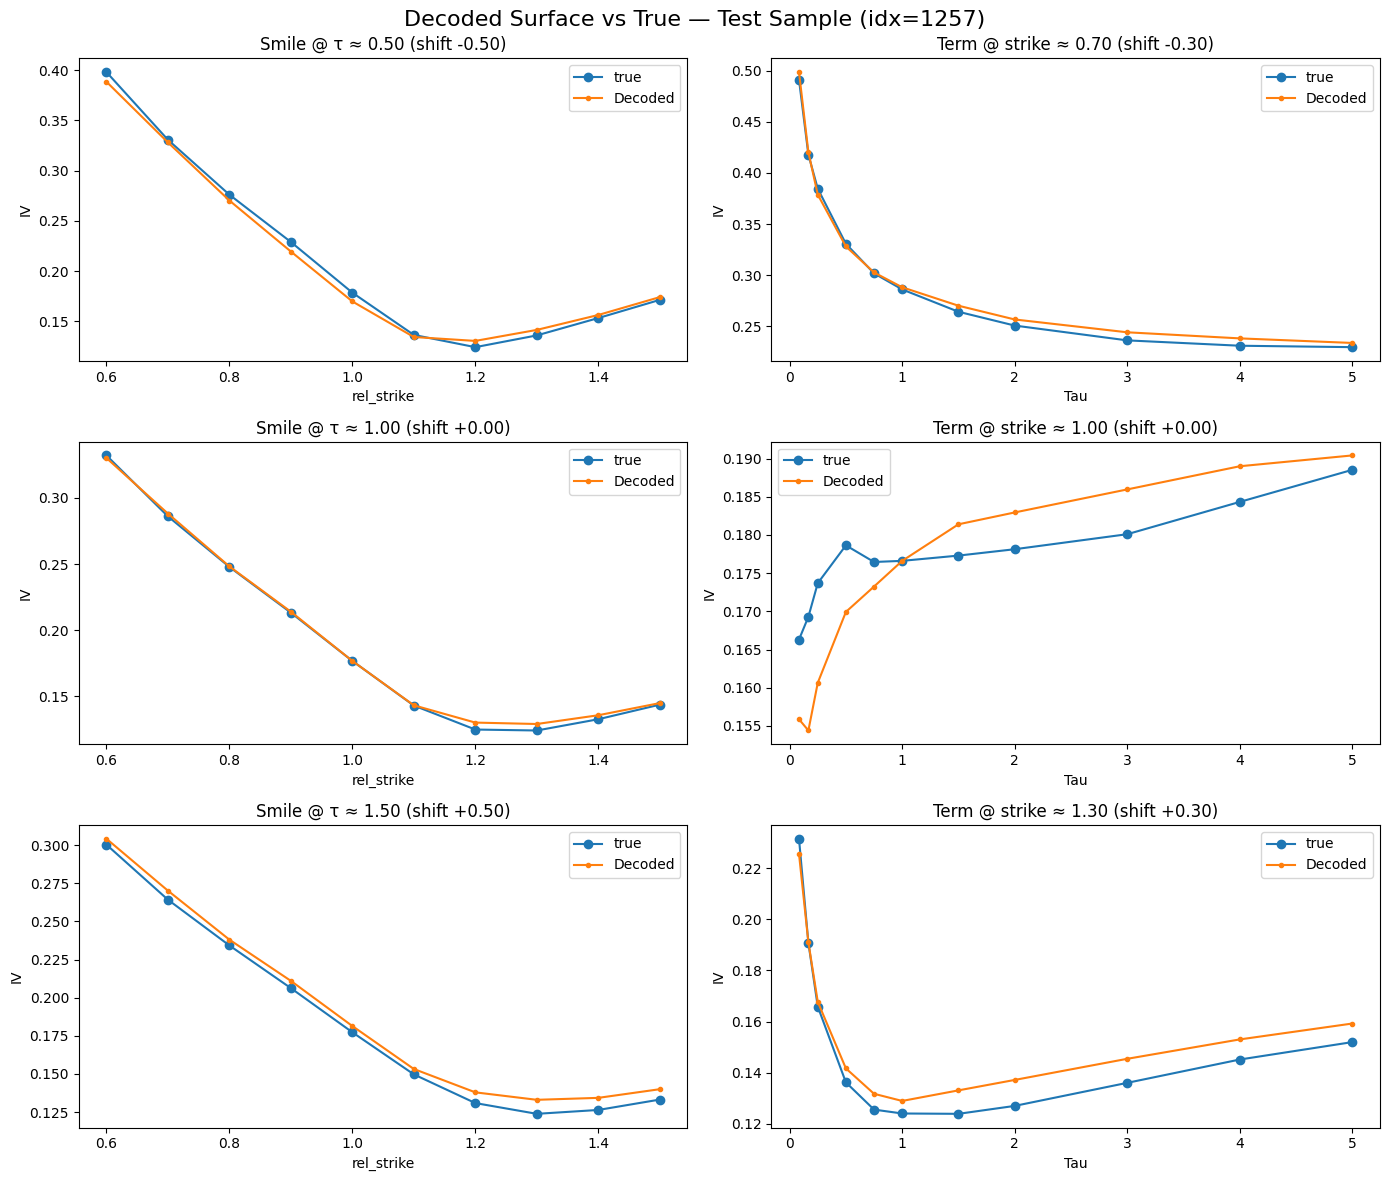

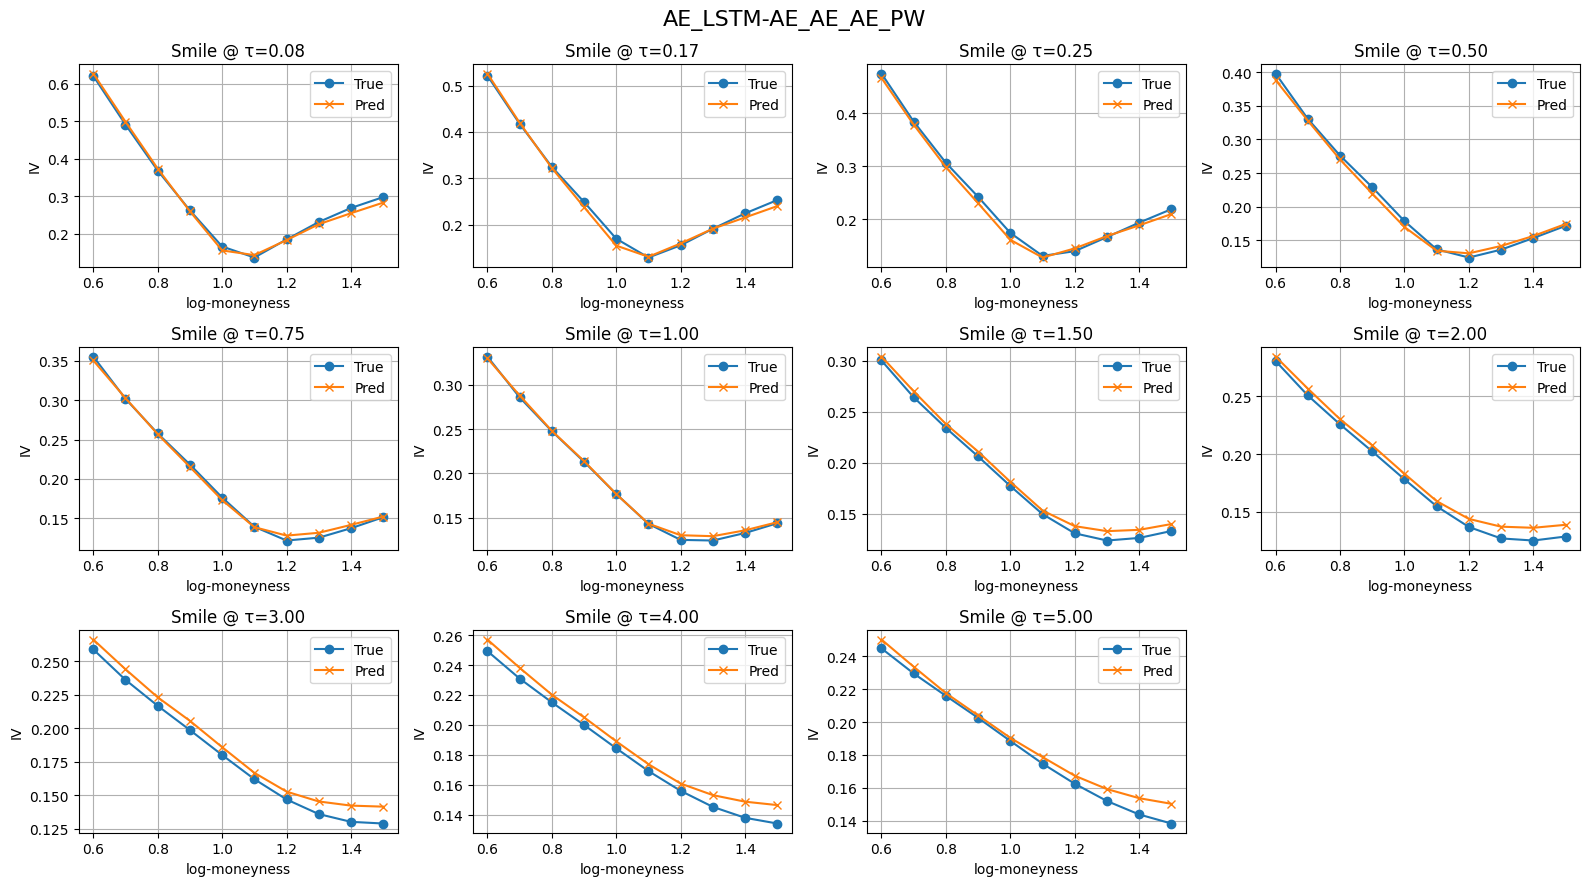

Sample violations - Smile: 2, Calendar: 0
Sample RMSE: 0.0068


In [18]:

from data.dataset import FeatureToLatentSequenceDataset
import matplotlib.pyplot as plt

def analyze_best_pipeline(df_results, pipelines, tensors, X_feat_tensor):
   """Analyze best pipeline using existing functions."""
   
   best_row = df_results.iloc[0]
   best_name = best_row['pipeline']
   best_pipeline = pipelines[best_name]
   
   print(f"Best Pipeline: {best_name}")
   print(f"Test RMSE: {best_row['test_rmse']:.4f}")
   print(f"Violations: {best_row['total_violations']}")
   
   encoder = best_pipeline['encoder']
   temporal = best_pipeline['temporal']
   decoder = best_pipeline['decoder']
   corrective = best_pipeline['corrective']
   
   # Use existing test split
   from data.tensor_builder import split_time_series_indices
   T = tensors["surface_tensor"].shape[0]
   train_idx, val_idx, test_idx = split_time_series_indices(T)

   # Slice tensors to test portion only
   test_surface = tensors["surface_tensor"][test_idx]
   test_features = X_feat_tensor[test_idx]

   test_dataset = FeatureToLatentSequenceDataset(
       surface_tensor=test_surface,
       feature_tensor=test_features,
       lookback=20,
       batch_size=32,
       global_indices=None  # Don't need global indices when already sliced
   )
   
   # Get prediction for one sample
   from models.lstm import EncodedLatentSequence
   
   if 'VAE' in best_name:
       encoder.predict_surface = lambda x, **kwargs: encoder(x, training=False)[1]
   
   encoded_sequences = EncodedLatentSequence(test_dataset, encoder)
   
   for z_seq, z_target in encoded_sequences:
       Z_forecast = temporal.predict(z_seq[:1], verbose=0)  # Just predict one
       break
   
   # Apply corrective decoder
   rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
   taus = ops.convert_to_numpy(tensors["taus"])
   
   m_grid, tau_grid = np.meshgrid(rel_strikes, taus)
   m_flat = m_grid.reshape(-1, 1).astype(np.float32)
   tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)
   
   
   actual_test_idx = test_idx[-1]  # Last test sample
   feat = ops.convert_to_numpy(X_feat_tensor[actual_test_idx])
   surface_pred = corrective.predict_surface(
       z=Z_forecast[0],
       f=feat,
       m_flat=m_flat,
       tau_flat=tau_flat
   )
   
   surface_true = ops.convert_to_numpy(tensors["surface_tensor"][actual_test_idx, :, :, -1])
   
   # Use V2 plotting functions
   from utils.eval import plot_iv_slices_shifts_v2, plot_smile_slices_comparison_v2
   
   plot_iv_slices_shifts_v2(
       true_surface=surface_true,
       decoded_surface=surface_pred,
       rel_strikes=rel_strikes,
       taus=taus,
       decoded_date=f"Test Sample (idx={actual_test_idx})",
       target_tau=1.0,
       target_strike=1.0
   )
   
   plot_smile_slices_comparison_v2(
       true_surface=surface_true,
       pred_surface=surface_pred,
       rel_strikes=rel_strikes,
       taus=taus,
       title=f"{best_name}"
   )
   
   # Arbitrage check
   from data.edav import check_no_arbitrage_total_variance
   smile_viol, cal_viol = check_no_arbitrage_total_variance(
       surface_pred, taus, rel_strikes, tol=0.005
   )
   print(f"Sample violations - Smile: {smile_viol}, Calendar: {cal_viol}")
   
   # Use edav error analysis
   from data.edav import analyze_reconstruction_errors
   error_analysis = analyze_reconstruction_errors(
       surface_true.reshape(1, 11, 10),
       surface_pred.reshape(1, 11, 10),
       M=11, K=10
   )
   print(f"Sample RMSE: {error_analysis['global_rmse']:.4f}")
   
   return surface_pred, surface_true
# run the function  
best_pred, best_true = analyze_best_pipeline(ranked_results, pipelines, tensors, X_feat_tensor)

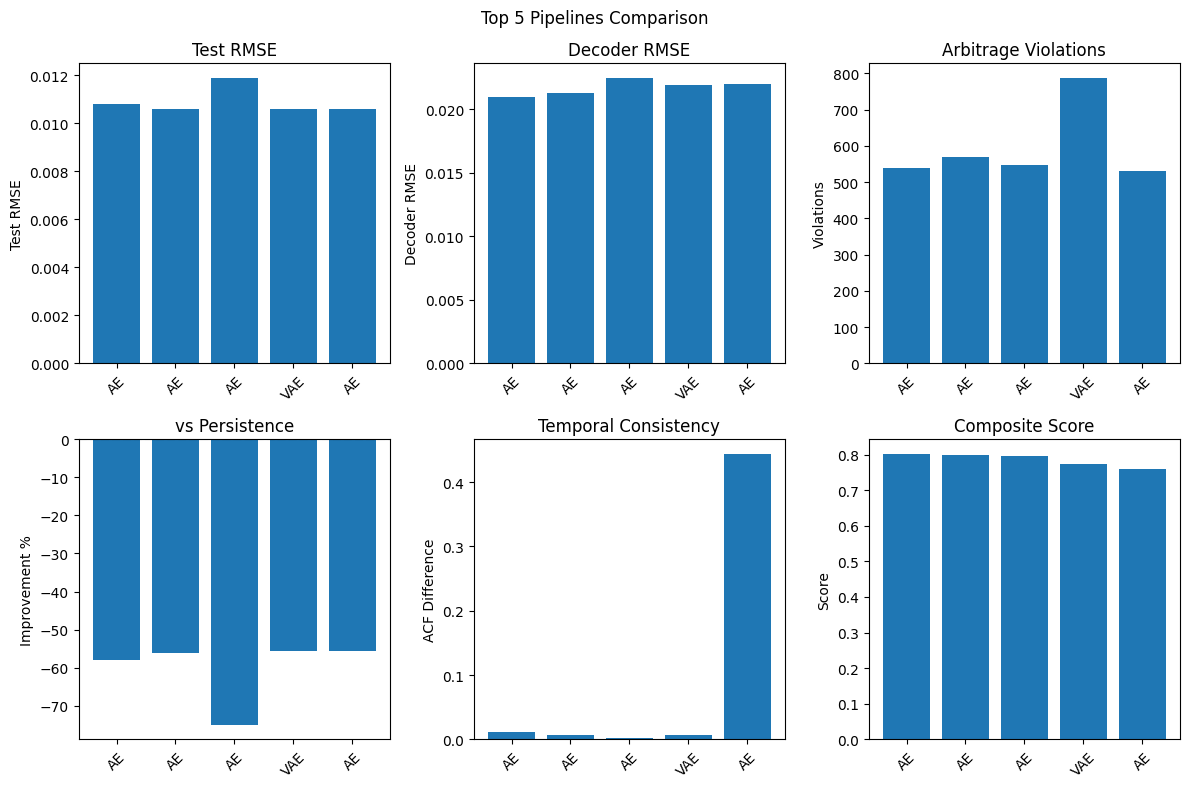

In [19]:

def compare_top_pipelines_errors(ranked_results, n_top=5):
   """Compare top pipelines using ranked results."""
   
   top_df = ranked_results.head(n_top)
   
   fig, axes = plt.subplots(2, 3, figsize=(12, 8))
   
   # RMSE comparison
   axes[0, 0].bar(range(n_top), top_df['test_rmse'].values)
   axes[0, 0].set_xticks(range(n_top))
   axes[0, 0].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[0, 0].set_ylabel('Test RMSE')
   axes[0, 0].set_title('Test RMSE')
   
   # Decoder RMSE
   axes[0, 1].bar(range(n_top), top_df['decoder_rmse'].values)
   axes[0, 1].set_xticks(range(n_top))
   axes[0, 1].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[0, 1].set_ylabel('Decoder RMSE')
   axes[0, 1].set_title('Decoder RMSE')
   
   # Violations
   axes[0, 2].bar(range(n_top), top_df['total_violations'].values)
   axes[0, 2].set_xticks(range(n_top))
   axes[0, 2].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[0, 2].set_ylabel('Violations')
   axes[0, 2].set_title('Arbitrage Violations')
   
   # Improvement over persistence (now available!)
   axes[1, 0].bar(range(n_top), top_df['improvement_over_persistence'].values * 100)
   axes[1, 0].set_xticks(range(n_top))
   axes[1, 0].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[1, 0].set_ylabel('Improvement %')
   axes[1, 0].set_title('vs Persistence')
   axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
   
   # Temporal consistency
   axes[1, 1].bar(range(n_top), top_df['latent_acf_diff'].values)
   axes[1, 1].set_xticks(range(n_top))
   axes[1, 1].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[1, 1].set_ylabel('ACF Difference')
   axes[1, 1].set_title('Temporal Consistency')
   
   # Composite score (now available!)
   axes[1, 2].bar(range(n_top), top_df['composite_score'].values)
   axes[1, 2].set_xticks(range(n_top))
   axes[1, 2].set_xticklabels([p.split('_')[0] for p in top_df['pipeline']], rotation=45)
   axes[1, 2].set_ylabel('Score')
   axes[1, 2].set_title('Composite Score')
   
   plt.suptitle(f'Top {n_top} Pipelines Comparison')
   plt.tight_layout()
   plt.show()



compare_top_pipelines_errors(ranked_results, n_top=5)



Available columns: ['pipeline', 'train_rmse', 'test_rmse', 'full_rmse', 'test_mae', 'decoder_rmse', 'persistence_rmse', 'latent_mse', 'latent_acf_diff', 'latent_var_ratio', 'smile_violations', 'calendar_violations', 'total_violations', 'is_problematic', 'problem_note']


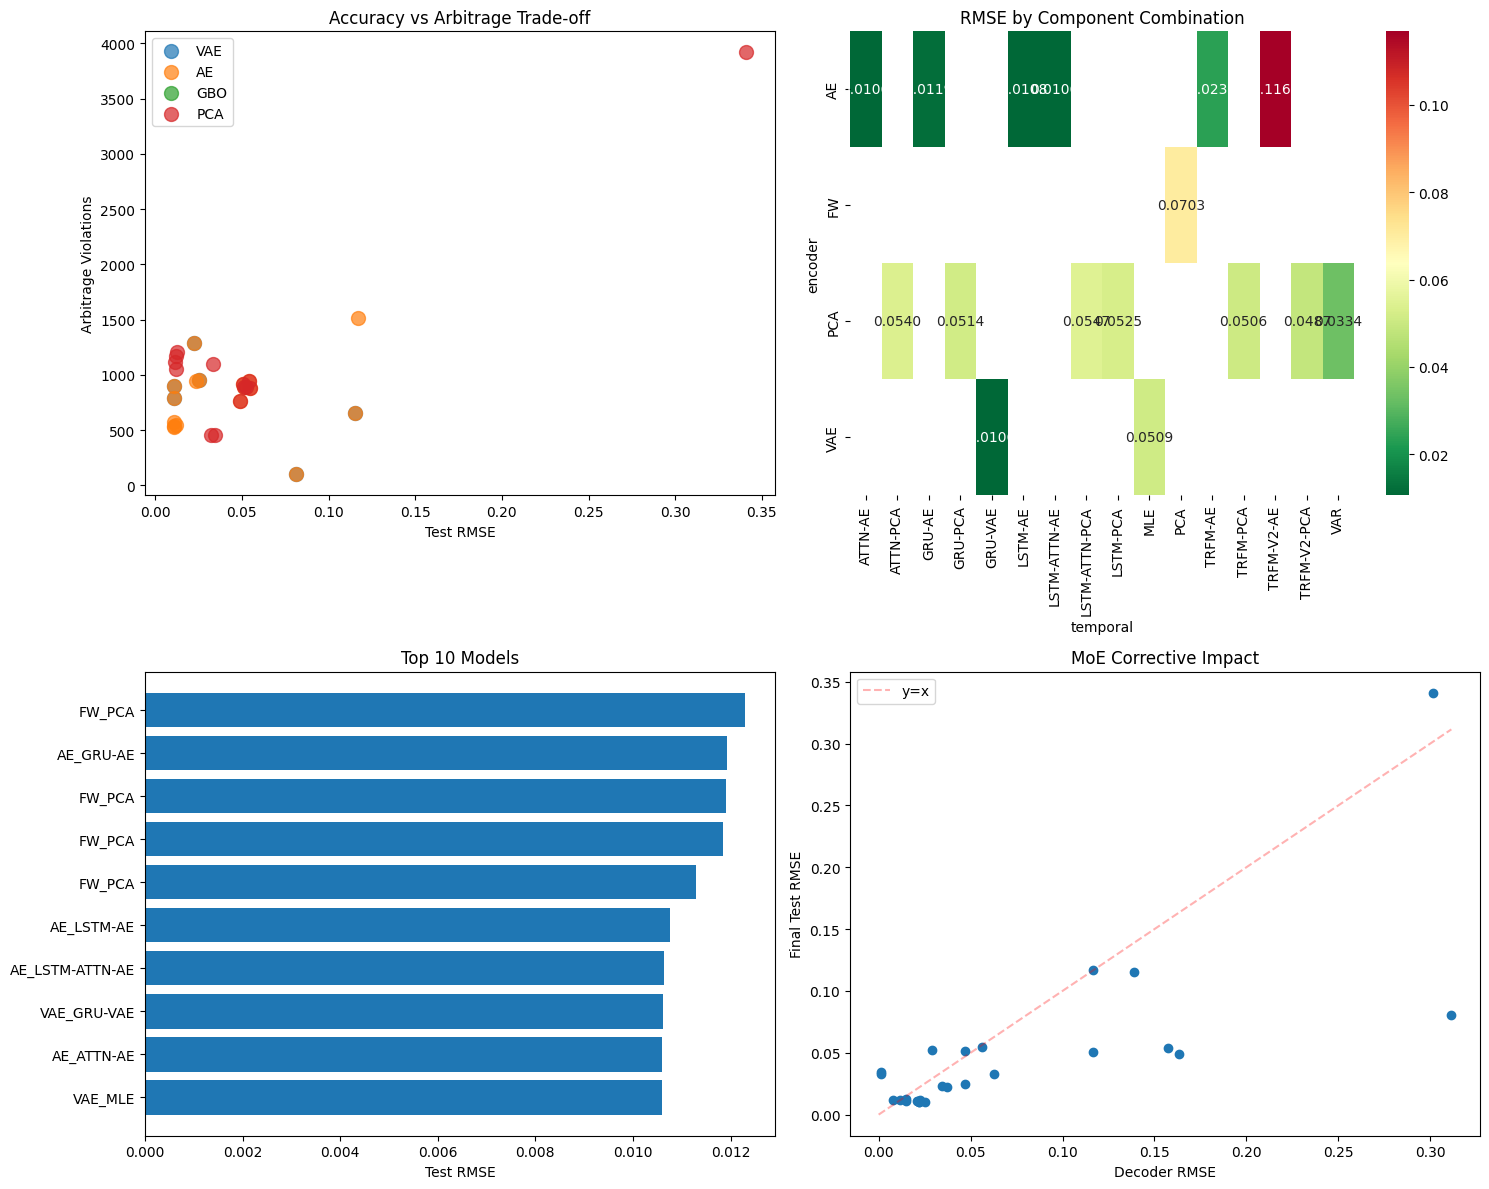

In [20]:
import seaborn as sns
print("Available columns:", df_results.columns.tolist())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#  RMSE vs Violations scatter
ax1 = axes[0, 0]
for pipeline_type in ['VAE', 'AE', 'GBO', 'PCA']:
    mask = df_results['pipeline'].str.contains(pipeline_type)
    subset = df_results[mask]
    ax1.scatter(subset['test_rmse'], subset['total_violations'], 
                label=pipeline_type, alpha=0.7, s=100)
ax1.set_xlabel('Test RMSE')
ax1.set_ylabel('Arbitrage Violations')
ax1.legend()
ax1.set_title('Accuracy vs Arbitrage Trade-off')

#  Component effectiveness heatmap
ax2 = axes[0, 1]
# Extract encoder and temporal model names more carefully
df_results['encoder'] = df_results['pipeline'].str.split('_').str[0]
df_results['temporal'] = df_results['pipeline'].str.split('_').str[1]
pivot_data = df_results.pivot_table(
    values='test_rmse',
    index='encoder',
    columns='temporal',
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax2)
ax2.set_title('RMSE by Component Combination')

#  Top models bar comparison
ax3 = axes[1, 0]
top_10 = df_results.nsmallest(10, 'test_rmse')
ax3.barh(range(len(top_10)), top_10['test_rmse'])
ax3.set_yticks(range(len(top_10)))
ax3.set_yticklabels([p.split('_')[0] + '_' + p.split('_')[1] for p in top_10['pipeline']])
ax3.set_xlabel('Test RMSE')
ax3.set_title('Top 10 Models')

#  Decoder vs Final RMSE 
ax4 = axes[1, 1]
ax4.scatter(df_results['decoder_rmse'], df_results['test_rmse'])
ax4.plot([0, df_results['decoder_rmse'].max()], 
         [0, df_results['decoder_rmse'].max()], 
         'r--', alpha=0.3, label='y=x')
ax4.set_xlabel('Decoder RMSE')
ax4.set_ylabel('Final Test RMSE')
ax4.set_title('MoE Corrective Impact')
ax4.legend()

plt.tight_layout()
plt.show()